# Timeline Analysis: Summary Results

In [1]:
from __future__ import print_function
import graphistry
import snap
from snap import TUNGraph
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import operator

# Set Seaborn defaults
sns.set()
%matplotlib inline
pd.set_option("display.precision", 6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 150
mpl.rcParams['figure.autolayout'] = True

# Global variables
data_dir = "../data"
pictures_path = os.path.join("../Pictures", "10.MicSummaryResults")

In [2]:
# Hashtags
hashtags = ["jesuischarlie", "brexit","makeamericagreatagain","isis","imwithher","trump","blacklivesmatter","alllivesmatter","indyref"]
hashtags_full = ["JeSuisCharlie","Brexit","MAGA","ISIS","ImWithHer","Trump","BLM","ALM","IndyRef"]

In [3]:
# Set colors by hashtag
colors = ["darksalmon","gold","seagreen","royalblue","purple","orange","tomato","slategrey","aquamarine"]
hashtag_color_dict = {h:k for h,k in zip(hashtags,colors)}

In [4]:
# Utility functions
def load_mic_before_after(hashtag):
    return pd.read_csv(os.path.join(data_dir,"mic_data","mic_before_after_"+hashtag+".csv"), dtype={"MIC Before": np.float32, "MIC After": np.float32})

def load_mic_total(hashtag):
    return pd.read_csv(os.path.join(data_dir,"mic_data","mic_total_"+hashtag+".csv"), dtype={"MIC Total": np.float32})

## 1. Mutual Interaction Consistency

In [5]:
# Load MIC data
mic_by_hashtag_dict = {h:{"total": load_mic_total(h), "before_after": load_mic_before_after(h)} for h in hashtags}

# Add hashtag column
for h,H in zip(hashtags, hashtags_full):
    mic_by_hashtag_dict[h]["before_after"]["Hashtag"] = pd.Series([H]*len(mic_by_hashtag_dict[h]["before_after"].index))

In [6]:
def plot_mic_observations(mic_by_hashtag_dict, plot_type="boxplot"):
    # Concatenate different DataFrames into a single one
    df = pd.concat([mic_by_hashtag_dict[h]["before_after"] for h in mic_by_hashtag_dict], ignore_index=True)
    if plot_type == "boxplot":
        df["MIC Total"] = pd.concat([mic_by_hashtag_dict[h]["total"] for h in mic_by_hashtag_dict], ignore_index=True)["MIC Total"]

    # Melt DF
    value_vars = ['MIC Before','MIC After', 'MIC Total'] if plot_type == "boxplot" else ['MIC Before','MIC After']
    df = pd.melt(df,id_vars=['Hashtag'], value_vars=value_vars, var_name='MIC', value_name="Mutual Interaction Consistency")

    # Set figure properties
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(12,10)
    fig.set_dpi(100)
    title = "Boxplots" if plot_type == "boxplot" else "Violinplots"
    ax.set_title("Mutual Interaction Consistency "+title+" by Hashtag", fontsize=14)
    fig.set_tight_layout(False)
    
    # Plot
    if plot_type == "boxplot":
        sns.boxplot(x='Mutual Interaction Consistency', y='Hashtag', data=df, hue='MIC', width=0.6, orient="h", palette="Set2", ax=ax)
    elif plot_type == "violinplot":
        sns.violinplot(x='Mutual Interaction Consistency', y='Hashtag', data=df, hue='MIC', orient="h", palette="Set2", ax=ax, split=True, inner="quart", )

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.savefig(os.path.join(pictures_path,"mic_"+plot_type+".png"))
    plt.show()

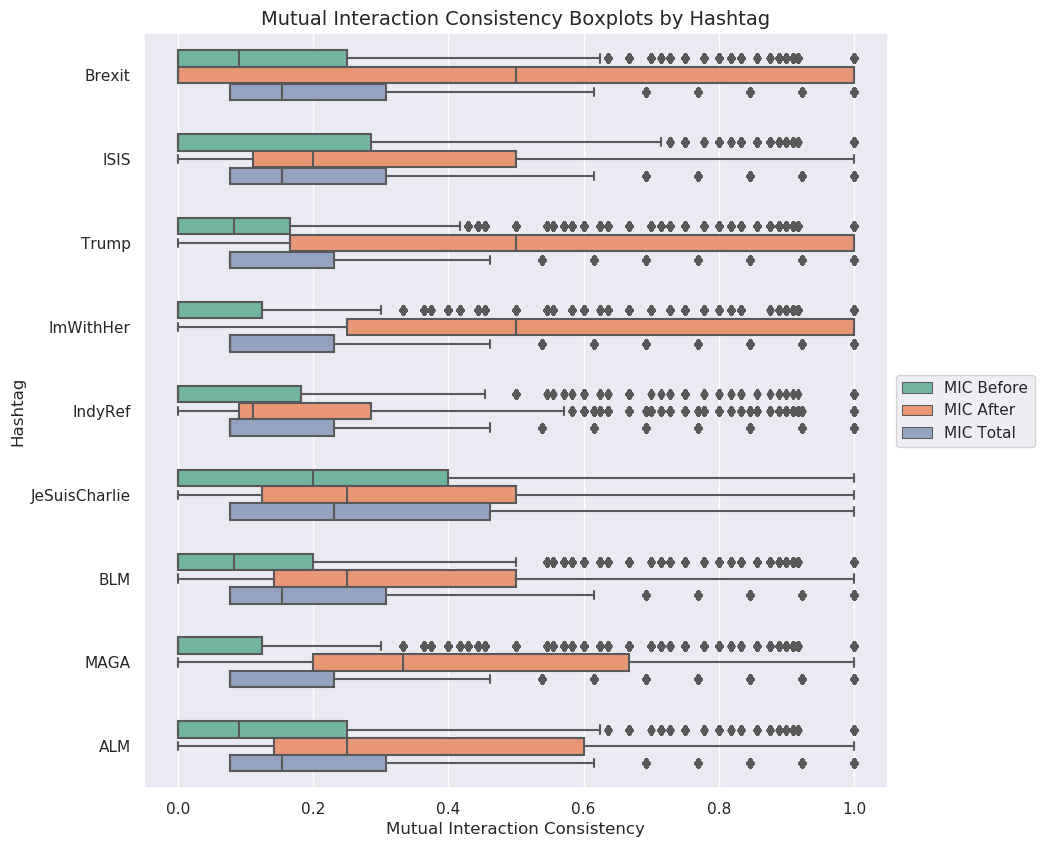

In [7]:
plot_mic_observations(mic_by_hashtag_dict)

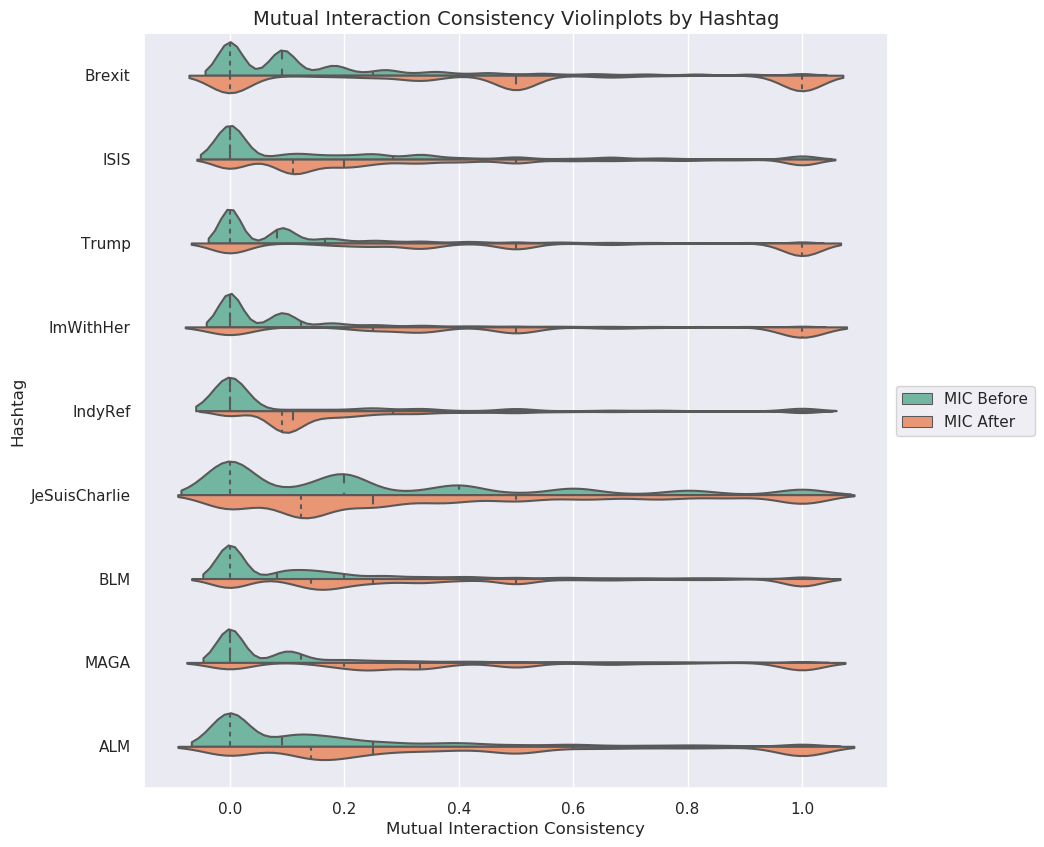

In [94]:
plot_mic_observations(mic_by_hashtag_dict, plot_type="violinplot")

## 2. Bonding Effect

In [61]:
def plot_bonding_effect(mic_by_hashtag_dict):
    # Format data
    temp_dfs = []
    for h in mic_by_hashtag_dict:
        temp = mic_by_hashtag_dict[h]["before_after"]
        temp["Bonding"] = temp["MIC After"] > temp["MIC Before"]
        temp = temp.groupby(by=["Hashtag","Bonding"])["MIC Before"].count().reset_index(name="Count")
        temp["Count %"] = temp["Count"]*100/float(temp.groupby(by="Hashtag")["Count"].sum())
        temp.drop(columns=["Count"], inplace=True)
        temp_dfs.append(temp)
    df = pd.concat([temp for temp in temp_dfs], ignore_index=True)
    
    # Set figure properties
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(12,4)
    fig.set_dpi(100)
    ax.set_title("Bonding Effect by Hashtag", fontsize=14)
    fig.set_tight_layout(False)
    
    # Plot
    sns.barplot(x="Hashtag", y="Count %", hue="Bonding", data=df, ax=ax, palette=["r","g"])
    ax.legend(loc='upper left')
    plt.savefig(os.path.join(pictures_path,"bonding_effect.png"))
    plt.show()

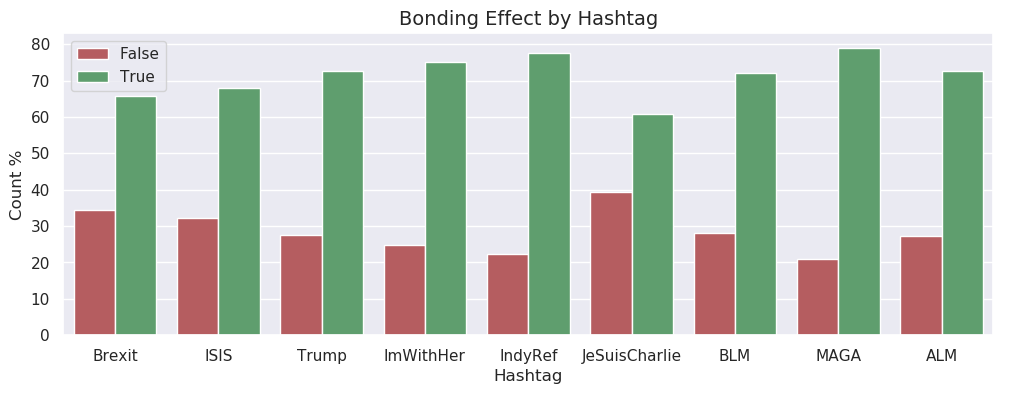

In [62]:
plot_bonding_effect(mic_by_hashtag_dict)

## 3. Sum of total communication by period

In [13]:
total_communication_by_period_dict = {}
for h in hashtags:
    total_communication_by_period_dict[h] = np.loadtxt(os.path.join(data_dir,h+"_fraction_of_communication_by_period.txt"))

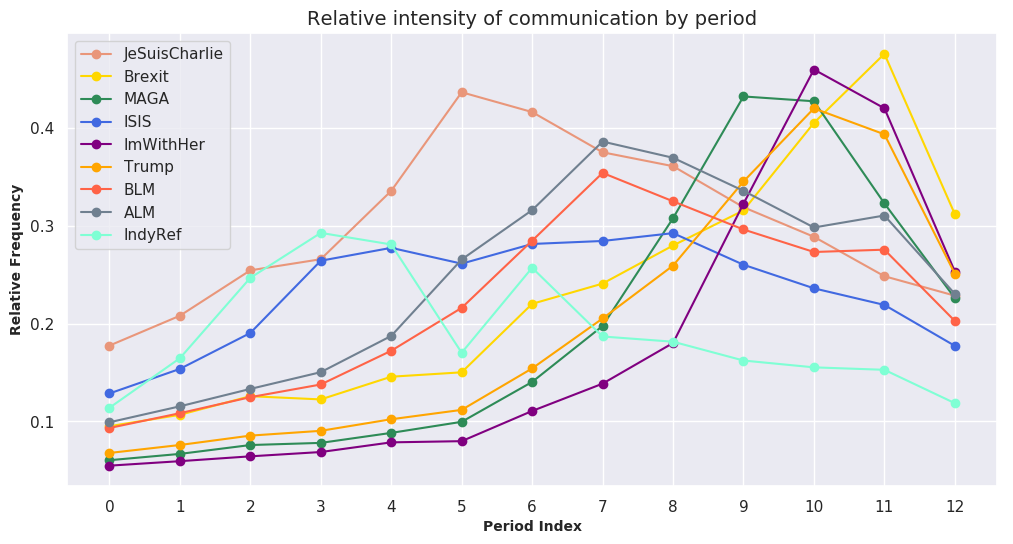

In [21]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,6)
fig.set_dpi(100)
ax.set_title("Relative intensity of communication by period", fontsize=14)
fig.set_tight_layout(False)
for h,H in zip(hashtags, hashtags_full):
    ax.plot(np.arange(0,13),total_communication_by_period_dict[h],linestyle='-', marker='o', label=H, color=hashtag_color_dict[h])
ax.legend()
ax.set_xticks(np.arange(0,13))
ax.set_xlabel("Period Index", fontsize=10, fontweight="bold")
ax.set_ylabel("Relative Frequency", fontsize=10, fontweight="bold")
plt.savefig(os.path.join(pictures_path,"intensity_communication_by_period.png"))
plt.show()